In [1]:
import os
def change_to_code_dir():
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == "p2ch15":
        parent_dir = os.path.dirname(current_dir)
        os.chdir(parent_dir)    
change_to_code_dir()

In [2]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from p2ch15.dsets import getCandidateInfoList, getCt, LunaDataset
from p2ch15.utils import get_sam_model
from PIL import Image
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
candidateInfo_list = getCandidateInfoList(require_on_disk=False)
positiveInfo_list = [x for x in candidateInfo_list if x[0]]
print(len(positiveInfo_list))

1351


In [4]:
ct_data = LunaDataset(positiveInfo_list)
len(ct_data)

2025-03-09 22:37:00,245 INFO     pid:12640 p2ch15.dsets:192:__init__ <p2ch15.dsets.LunaDataset object at 0x000001AFE8513FE0>: 1351 training samples


1351

In [5]:
from segment_anything import SamPredictor, sam_model_registry
model_config, model_weights_path = get_sam_model()

sam = sam_model_registry[model_config](checkpoint=model_weights_path)
sam.to(device)

c:\Users\howardhuang\MyCode\DeepLearningWithPytorch-SecondEdition\.venv\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  st

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [ ]:
fine_tuning_dir = "data-unversioned/part2/fine-tuning/dataset"
ct_folder = f"{fine_tuning_dir}/ct"
mask_folder = f"{fine_tuning_dir}/mask"
metadata_folder = f"{fine_tuning_dir}/"
def normalize_tensor(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    scaled_tensor = (normalized_tensor * 255).clamp(0, 255).byte()
    return scaled_tensor

def generate_ct_images_and_masks(original_ct_data, max_dataset_size=500, recompute=False):
    os.makedirs(ct_folder, exist_ok=True)
    os.makedirs(mask_folder, exist_ok=True)
    os.makedirs(metadata_folder, exist_ok=True)

    metadata_filepath = os.path.join(metadata_folder, "metadata.jsonl")
    existing_metadata = set()
    # Check if the metadata.jsonl file exists and load existing entries
    if os.path.exists(metadata_filepath):
        with open(metadata_filepath, 'r') as f:
            for line in f:
                row = json.loads(line)
                existing_metadata.add(int(row['index']))

    max_index_seen = max(existing_metadata) if existing_metadata else -1
    with open(metadata_filepath, 'a') as f:
        ct_data_index = 0
        for ct_slice, _, series_uid, center_irc in original_ct_data:
            if len(existing_metadata) >= max_dataset_size:
                print("finished")
                break
            
            scaled_ct_slice = normalize_tensor(ct_slice.repeat(3, 1, 1))
            filename = f"{ct_data_index}.png"  # Monotonically increasing filename

            # Check if data already is saved
            center_irc_list = center_irc.numpy().tolist()
            if ct_data_index < max_index_seen and not recompute :
                ct_data_index += 1
                continue

            ct_filepath = os.path.join(ct_folder, filename)
            mask_filepath = os.path.join(mask_folder, filename)
            if not os.path.exists(ct_filepath) or not os.path.exists(mask_filepath) or recompute:
                # ct image
                ct_image_array = np.transpose(scaled_ct_slice.numpy(), (1, 2, 0))
                ct_image = Image.fromarray(ct_image_array, mode="RGB")

                # mask image
                x, y = center_irc[2], center_irc[1]
                input_points = [[x, y]]
                predictor = SamPredictor(sam)
                predictor.set_image(ct_image_array)
                masks, iou_predictions, _ = predictor.predict(point_coords=np.array(input_points), point_labels=np.array([1]), multimask_output=False)
                mask_image_array = masks[0]
                mask_area = np.sum(mask_image_array)
                mask_image = Image.fromarray(mask_image_array)

                # save only if the mask is good
                if mask_area < 1100 and iou_predictions[0] > 0.88:
                    ct_image.save(ct_filepath)
                    mask_image.save(mask_filepath)
                else:
                    ct_data_index += 1
                    continue
    
            # Calculate relative paths
            relative_ct_path = os.path.relpath(ct_filepath, start=fine_tuning_dir).replace("\\", "/")
            relative_mask_path = os.path.relpath(mask_filepath, start=fine_tuning_dir).replace("\\", "/")
            metadata_item = {
                "index": ct_data_index,
                "series_uid": series_uid,
                "center_irc": center_irc_list,
                "ct_file_name": relative_ct_path,
                "mask_file_name": relative_mask_path
            }
            # Write each metadata item as a JSON object in the JSONL file
            f.write(json.dumps(metadata_item) + '\n')
            existing_metadata.add(ct_data_index)
            ct_data_index += 1

# Example usage
ct_data = LunaDataset(positiveInfo_list, sortby_str="label_and_size")
generate_ct_images_and_masks(ct_data, max_dataset_size=500)

2025-03-08 02:18:50,296 INFO     pid:21136 p2ch15.dsets:192:__init__ <p2ch15.dsets.LunaDataset object at 0x0000021373857530>: 1351 training samples


finished


In [ ]:
# Saving the data/images to hugging face

# from huggingface_hub import upload_folder
# repo_id = "H-Huang/LUNA16_segmentation_data"
# upload_folder(
#     folder_path=fine_tuning_dir,
#     repo_id=repo_id,
#     repo_type="dataset",  # Specify that this is a dataset repository
#     commit_message="Upload LUNA16 segmentation data"
# )

CommitInfo(commit_url='https://huggingface.co/datasets/H-Huang/LUNA16_segmentation_data/commit/a74dadcaddf323b774b5ba2365084dda6c2a4d10', commit_message='Upload LUNA16 segmentation data', commit_description='', oid='a74dadcaddf323b774b5ba2365084dda6c2a4d10', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Loading the data/images from hugging face

if not os.path.exists(fine_tuning_dir):
    from huggingface_hub import snapshot_download
    repo_id = "H-Huang/LUNA16_segmentation_data"
    snapshot_download(repo_id=repo_id, local_dir=fine_tuning_dir, repo_type="dataset")

In [6]:
fine_tuning_dir = "data-unversioned/part2/fine-tuning/dataset"
ct_folder = f"{fine_tuning_dir}/ct"
mask_folder = f"{fine_tuning_dir}/mask"
metadata_folder = f"{fine_tuning_dir}/"

class FineTuningDataset(Dataset):
    def __init__(
        self,
        fine_tuning_dir=fine_tuning_dir,
        ct_folder=ct_folder,
        mask_folder=mask_folder,
        metadata_folder=metadata_folder,
        split="train",  # 'train' or 'val'
        train_ratio=0.8,  # Ratio of data to use for training
    ):
        self.fine_tuning_dir = fine_tuning_dir
        self.metadata_folder = metadata_folder

        # Create folders if they don't exist
        if (
            not os.path.exists(ct_folder)
            or not os.path.exists(mask_folder)
            or not os.path.exists(metadata_folder)
        ):
            raise RuntimeError("'generate_ct_images_and_masks()' must be called first")

        metadata_filepath = os.path.join(metadata_folder, "metadata.jsonl")
        self.metadata_list = []
        # Read the JSONL file
        with open(metadata_filepath, "r") as f:
            for line in f:
                # Parse each line as a JSON object
                row = json.loads(line.strip())
                # Check if the row is not empty
                if row:  # This checks if the row is not an empty dictionary
                    self.metadata_list.append(row)

        # Determine the split indices
        total_length = len(self.metadata_list)
        train_length = int(total_length * train_ratio)

        if split == "train":
            self.metadata_list = self.metadata_list[:train_length]
        elif split == "val":
            self.metadata_list = self.metadata_list[train_length:]
        else:
            raise ValueError("split must be 'train' or 'val'")

    def __len__(self):
        return len(self.metadata_list)

    def __getitem__(self, index):
        metadata = self.metadata_list[index]
        ct_image_path = f"{self.fine_tuning_dir}/{metadata['ct_file_name']}"
        mask_image_path = f"{self.fine_tuning_dir}/{metadata['mask_file_name']}"
        series_uid = metadata["series_uid"]
        center_irc = metadata["center_irc"]

        return {
            "series_uid": series_uid,
            "center_irc": torch.tensor(center_irc),
            "ct_image_path": ct_image_path,
            "mask_image_path": mask_image_path,
        }
fine_tuning_data = FineTuningDataset()

In [7]:
len(fine_tuning_data)

400

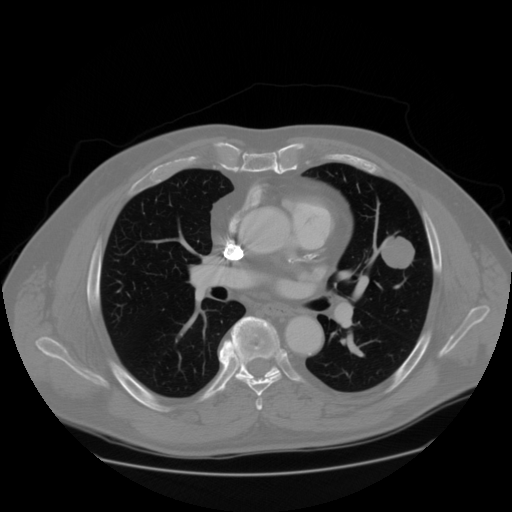

In [10]:
Image.open(fine_tuning_data[1]["ct_image_path"])